# Training and Evaluating LeNet-5 on the GTSRB dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # unfortunately, we cannot import our helper scripts directly on Google Colab as other files from our repo are not accessible
  # we have to clone our GitHub repo to fetch the helper scripts and add the script folder of cloned repo to the syspath

  print('Notebook running on Google Colab')
  repo_path = './ml-ex3'
  repo_git_url = 'https://github.com/Sejmou/ml-ex3.git'

  import subprocess
  import sys

  def install(package):#https://stackoverflow.com/a/50255019/13727176
    print(f'Installing {package} using pip')
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
  
  if 'git' not in sys.modules:
    install('GitPython')
  
  from git import Repo

  if os.path.exists(repo_path): # already cloned -> pull latest changes
    print('pulling from our git repo to get latest version of helper scripts')
    repo = Repo(repo_path)
    o = repo.remotes.origin
    o.pull()
    print('pulled successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')
    import importlib
    import helper_scripts
    importlib.reload(helper_scripts)
    print('reloaded helper_scripts module')
  else:
    print('cloning our git repo to get helper scripts')
    Repo.clone_from(repo_git_url, repo_path)
    print('cloned successfully')
    sys.path.append(f'{repo_path}/notebooks')
    print('appended helper_scripts module to sys.path')

  from google.colab import drive
  drive.mount('/content/drive')
  root_log_dir = f'/content/drive/MyDrive/ml-ex3/GTSRB/LeNet/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'#pick drive folder that suits you
else:
  root_log_dir = f'../model_fit_results/GTSRB/LeNet/{datetime.now().strftime("%Y-%m-%d_%H_%M_%S")}'

## Loading the data

LeNet takes an image of shape 32x32x1 in the input layer (i.e., the images should all be grayscale). Furthermore, the input image intensity values should be normalized. We get the images in the desired format from our data loader:

In [3]:
from helper_scripts.data_loaders import GTSRBLoader

data_loader = GTSRBLoader('../data/GTSRB')

X_train, X_val, X_test, y_train, y_val, y_test = data_loader.get_processed_imgs(target_width=32, target_height=32,
                                                        normalize=True, convert_to_grayscale=True)

GTSRB dataset already downloaded, loading files from memory
loading training images and labels
loading test images and labels
done
processing training images
processing test images
done processing, creating train/val/test split


Let's have a quick look at what the data we got back looks like:

In [4]:
from helper_scripts.data_exploration import print_dataset_summary, show_img

print_dataset_summary(data=(X_train, X_val, X_test, y_train, y_val, y_test), dataset_name='GTSRB')


--- Checking loaded GTSRB data ---
Data types
X_train: <class 'numpy.ndarray'>
X_val: <class 'numpy.ndarray'>
X_test: <class 'numpy.ndarray'>
y_train: <class 'numpy.ndarray'>
y_val: <class 'numpy.ndarray'>
y_test: <class 'numpy.ndarray'>

Data shapes
X_train: (27446, 32, 32)
X_val: (11763, 32, 32)
X_test: (12630, 32, 32)
y_train: (27446,)
y_val: (11763,)
y_test: (12630,)

Image stats:
shape: (51839, 32, 32)
Max value across all images and channels: 0.9998999999999999
Min value across all images and channels: 0.0
Split sizes:
 train size: 27446
validation size: 11763
test size: 12630
Total dataset size: 51839

Train/Val/Test ratio: 0.53/0.23/0.24
Train/Val ratio:0.7/0.3
(Train+Val)/Test ratio:0.76/0.24


We notice that y_train, y_val, and y_test are in the wrong shape to be used by Keras classifiers. We need to one-hot-encode them:

In [5]:
from tensorflow.keras.utils import to_categorical 

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

Let's also have a look at an example image from the train, test, and validation datasets:

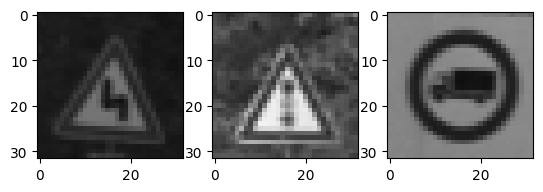

In [6]:
fig, ax = plt.subplots(1, 3)

for i, split in enumerate([X_train, X_val, X_test]):
  show_img(split[0], ax=ax[i], val_range_min=0, val_range_max=1)

plt.show()

Finally, let's remind ourselves what classes the dataset contains:

In [7]:
data_loader.text_label_dict

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing veh over 3.5 tons',
 11: 'Right-of-way at intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Veh > 3.5 tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve left',
 20: 'Dangerous curve right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End speed + passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go straight or right',
 37: 'Go straight or left',
 38: 'Keep right'

## Defining the Model (based on [this](https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086)):

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import AveragePooling2D

def LeNetModel(num_classes):
  model = Sequential()

  model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
  model.add(AveragePooling2D())

  model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(AveragePooling2D())

  model.add(Flatten())

  model.add(Dense(units=120, activation='relu'))

  model.add(Dense(units=84, activation='relu'))

  model.add(Dense(units=num_classes, activation = 'softmax'))
  return model

### Fitting w/o Data Augmentation:

In [9]:
loss = 'binary_crossentropy' 
optimizer = 'sgd'
num_classes = data_loader.number_of_classes

model = LeNetModel(num_classes)
model.compile(loss=loss , optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [10]:
epochs = 300
batch_size=32

### Adding callbacks

We will use three callbacks: one for storing the best model weights, one custom callback for measuring the fit time, and one for logging the training process to TensorBoard.

In [11]:
from keras.callbacks import ModelCheckpoint

log_dir = os.path.join(root_log_dir, 'no_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)




In [12]:
from helper_scripts.deep_learning import TimeHistory
time_cb = TimeHistory()

In [13]:
from keras.callbacks import TensorBoard

tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

In [14]:
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data= (X_val, y_val),
    callbacks=[checkpoint_cb, time_cb, tensorboard_cb]
)

Epoch 1/300
858/858 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.0417
Epoch 1: val_accuracy improved from -inf to 0.05262, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 5s 4ms/step - loss: 0.4408 - accuracy: 0.0417 - val_loss: 0.1124 - val_accuracy: 0.0526
Epoch 2/300
845/858 [============================>.] - ETA: 0s - loss: 0.1091 - accuracy: 0.0590
Epoch 2: val_accuracy improved from 0.05262 to 0.06988, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step - loss: 0.1091 - accuracy: 0.0589 - val_loss: 0.1073 - val_accuracy: 0.0699
Epoch 3/300
842/858 [============================>.] - ETA: 0s - loss: 0.1066 - accuracy: 0.0594
Epoch 3: val_accuracy improved from 0.06988 to 0.08221, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_

856/858 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.0722
Epoch 28: val_accuracy did not improve from 0.10406
858/858 [==============================] - 3s 4ms/step - loss: 0.1037 - accuracy: 0.0721 - val_loss: 0.1036 - val_accuracy: 0.1024
Epoch 29/300
856/858 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.0706
Epoch 29: val_accuracy did not improve from 0.10406
858/858 [==============================] - 3s 4ms/step - loss: 0.1037 - accuracy: 0.0708 - val_loss: 0.1036 - val_accuracy: 0.0716
Epoch 30/300
855/858 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.0714
Epoch 30: val_accuracy did not improve from 0.10406
858/858 [==============================] - 3s 4ms/step - loss: 0.1036 - accuracy: 0.0715 - val_loss: 0.1036 - val_accuracy: 0.0583
Epoch 31/300
842/858 [============================>.] - ETA: 0s - loss: 0.1036 - accuracy: 0.0766
Epoch 31: val_accuracy did not improve from 0.10406
858/858 [===========

853/858 [============================>.] - ETA: 0s - loss: 0.1018 - accuracy: 0.1003
Epoch 57: val_accuracy did not improve from 0.10406
858/858 [==============================] - 3s 4ms/step - loss: 0.1018 - accuracy: 0.1001 - val_loss: 0.1019 - val_accuracy: 0.1010
Epoch 58/300
851/858 [============================>.] - ETA: 0s - loss: 0.1017 - accuracy: 0.0998
Epoch 58: val_accuracy did not improve from 0.10406
858/858 [==============================] - 3s 4ms/step - loss: 0.1017 - accuracy: 0.0998 - val_loss: 0.1019 - val_accuracy: 0.0989
Epoch 59/300
848/858 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.0998
Epoch 59: val_accuracy did not improve from 0.10406
858/858 [==============================] - 3s 4ms/step - loss: 0.1016 - accuracy: 0.0994 - val_loss: 0.1017 - val_accuracy: 0.0944
Epoch 60/300
855/858 [============================>.] - ETA: 0s - loss: 0.1016 - accuracy: 0.1020
Epoch 60: val_accuracy did not improve from 0.10406
858/858 [===========

858/858 [==============================] - 4s 4ms/step - loss: 0.0995 - accuracy: 0.1184 - val_loss: 0.0997 - val_accuracy: 0.1148
Epoch 84/300
854/858 [============================>.] - ETA: 0s - loss: 0.0994 - accuracy: 0.1181
Epoch 84: val_accuracy improved from 0.11630 to 0.12191, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step - loss: 0.0994 - accuracy: 0.1180 - val_loss: 0.0995 - val_accuracy: 0.1219
Epoch 85/300
857/858 [============================>.] - ETA: 0s - loss: 0.0993 - accuracy: 0.1219
Epoch 85: val_accuracy did not improve from 0.12191
858/858 [==============================] - 3s 4ms/step - loss: 0.0993 - accuracy: 0.1219 - val_loss: 0.0994 - val_accuracy: 0.1197
Epoch 86/300
853/858 [============================>.] - ETA: 0s - loss: 0.0991 - accuracy: 0.1227
Epoch 86: val_accuracy did not improve from 0.12191
858/858 [==============================] - 3

858/858 [==============================] - 3s 3ms/step - loss: 0.0938 - accuracy: 0.1844 - val_loss: 0.0938 - val_accuracy: 0.1849
Epoch 106/300
849/858 [============================>.] - ETA: 0s - loss: 0.0933 - accuracy: 0.1908
Epoch 106: val_accuracy improved from 0.18490 to 0.19612, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 3ms/step - loss: 0.0933 - accuracy: 0.1907 - val_loss: 0.0933 - val_accuracy: 0.1961
Epoch 107/300
850/858 [============================>.] - ETA: 0s - loss: 0.0928 - accuracy: 0.1996
Epoch 107: val_accuracy did not improve from 0.19612
858/858 [==============================] - 3s 3ms/step - loss: 0.0928 - accuracy: 0.1990 - val_loss: 0.0929 - val_accuracy: 0.1910
Epoch 108/300
843/858 [============================>.] - ETA: 0s - loss: 0.0923 - accuracy: 0.2045
Epoch 108: val_accuracy improved from 0.19612 to 0.21143, saving model to ../model_fit_resu

858/858 [==============================] - 3s 3ms/step - loss: 0.0797 - accuracy: 0.3503 - val_loss: 0.0799 - val_accuracy: 0.3499
Epoch 128/300
853/858 [============================>.] - ETA: 0s - loss: 0.0789 - accuracy: 0.3582
Epoch 128: val_accuracy improved from 0.34991 to 0.35518, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 3ms/step - loss: 0.0789 - accuracy: 0.3581 - val_loss: 0.0791 - val_accuracy: 0.3552
Epoch 129/300
848/858 [============================>.] - ETA: 0s - loss: 0.0782 - accuracy: 0.3659
Epoch 129: val_accuracy improved from 0.35518 to 0.35552, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 3ms/step - loss: 0.0782 - accuracy: 0.3661 - val_loss: 0.0785 - val_accuracy: 0.3555
Epoch 130/300
847/858 [============================>.] - ETA: 0s - loss: 0.07

858/858 [==============================] - 4s 5ms/step - loss: 0.0632 - accuracy: 0.5252 - val_loss: 0.0638 - val_accuracy: 0.5198
Epoch 149/300
852/858 [============================>.] - ETA: 0s - loss: 0.0624 - accuracy: 0.5307
Epoch 149: val_accuracy improved from 0.51977 to 0.52759, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step - loss: 0.0624 - accuracy: 0.5309 - val_loss: 0.0631 - val_accuracy: 0.5276
Epoch 150/300
845/858 [============================>.] - ETA: 0s - loss: 0.0618 - accuracy: 0.5407
Epoch 150: val_accuracy improved from 0.52759 to 0.53048, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 3ms/step - loss: 0.0617 - accuracy: 0.5409 - val_loss: 0.0626 - val_accuracy: 0.5305
Epoch 151/300
844/858 [============================>.] - ETA: 0s - loss: 0.06

844/858 [============================>.] - ETA: 0s - loss: 0.0494 - accuracy: 0.6533
Epoch 171: val_accuracy improved from 0.64167 to 0.64796, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 3ms/step - loss: 0.0494 - accuracy: 0.6535 - val_loss: 0.0505 - val_accuracy: 0.6480
Epoch 172/300
846/858 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.6556
Epoch 172: val_accuracy did not improve from 0.64796
858/858 [==============================] - 3s 3ms/step - loss: 0.0489 - accuracy: 0.6563 - val_loss: 0.0502 - val_accuracy: 0.6433
Epoch 173/300
849/858 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.6619
Epoch 173: val_accuracy did not improve from 0.64796
858/858 [==============================] - 3s 3ms/step - loss: 0.0484 - accuracy: 0.6616 - val_loss: 0.0504 - val_accuracy: 0.6404
Epoch 174/300
855/858 [============================>

Epoch 195/300
843/858 [============================>.] - ETA: 0s - loss: 0.0395 - accuracy: 0.7337
Epoch 195: val_accuracy improved from 0.72320 to 0.72482, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 3ms/step - loss: 0.0395 - accuracy: 0.7338 - val_loss: 0.0411 - val_accuracy: 0.7248
Epoch 196/300
854/858 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.7364
Epoch 196: val_accuracy did not improve from 0.72482
858/858 [==============================] - 3s 4ms/step - loss: 0.0392 - accuracy: 0.7363 - val_loss: 0.0408 - val_accuracy: 0.7245
Epoch 197/300
845/858 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.7391
Epoch 197: val_accuracy did not improve from 0.72482
858/858 [==============================] - 3s 3ms/step - loss: 0.0389 - accuracy: 0.7387 - val_loss: 0.0403 - val_accuracy: 0.7238
Epoch 198/300
854/858 [===============

846/858 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.7879
Epoch 219: val_accuracy did not improve from 0.77455
858/858 [==============================] - 3s 4ms/step - loss: 0.0326 - accuracy: 0.7880 - val_loss: 0.0352 - val_accuracy: 0.7675
Epoch 220/300
847/858 [============================>.] - ETA: 0s - loss: 0.0324 - accuracy: 0.7907
Epoch 220: val_accuracy improved from 0.77455 to 0.78322, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step - loss: 0.0324 - accuracy: 0.7906 - val_loss: 0.0337 - val_accuracy: 0.7832
Epoch 221/300
846/858 [============================>.] - ETA: 0s - loss: 0.0322 - accuracy: 0.7909
Epoch 221: val_accuracy improved from 0.78322 to 0.78594, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step - loss: 0.0322 

Epoch 245/300
848/858 [============================>.] - ETA: 0s - loss: 0.0274 - accuracy: 0.8309
Epoch 245: val_accuracy did not improve from 0.81484
858/858 [==============================] - 3s 4ms/step - loss: 0.0274 - accuracy: 0.8307 - val_loss: 0.0306 - val_accuracy: 0.7944
Epoch 246/300
844/858 [============================>.] - ETA: 0s - loss: 0.0273 - accuracy: 0.8328
Epoch 246: val_accuracy improved from 0.81484 to 0.81518, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step - loss: 0.0273 - accuracy: 0.8324 - val_loss: 0.0293 - val_accuracy: 0.8152
Epoch 247/300
843/858 [============================>.] - ETA: 0s - loss: 0.0272 - accuracy: 0.8314
Epoch 247: val_accuracy improved from 0.81518 to 0.82326, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step -

Epoch 271/300
844/858 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.8598
Epoch 271: val_accuracy did not improve from 0.84315
858/858 [==============================] - 3s 4ms/step - loss: 0.0238 - accuracy: 0.8595 - val_loss: 0.0261 - val_accuracy: 0.8409
Epoch 272/300
847/858 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.8592
Epoch 272: val_accuracy did not improve from 0.84315
858/858 [==============================] - 3s 4ms/step - loss: 0.0237 - accuracy: 0.8590 - val_loss: 0.0260 - val_accuracy: 0.8409
Epoch 273/300
858/858 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 0.8607
Epoch 273: val_accuracy improved from 0.84315 to 0.84757, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/no_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 3s 4ms/step - loss: 0.0236 - accuracy: 0.8607 - val_loss: 0.0259 - val_accuracy: 0.8476
Epoch 274/300
855/858 [===============

858/858 [==============================] - 3s 4ms/step - loss: 0.0210 - accuracy: 0.8813 - val_loss: 0.0237 - val_accuracy: 0.8593
Epoch 297/300
850/858 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.8800
Epoch 297: val_accuracy did not improve from 0.86509
858/858 [==============================] - 3s 4ms/step - loss: 0.0210 - accuracy: 0.8799 - val_loss: 0.0248 - val_accuracy: 0.8513
Epoch 298/300
853/858 [============================>.] - ETA: 0s - loss: 0.0210 - accuracy: 0.8799
Epoch 298: val_accuracy did not improve from 0.86509
858/858 [==============================] - 3s 4ms/step - loss: 0.0210 - accuracy: 0.8801 - val_loss: 0.0239 - val_accuracy: 0.8589
Epoch 299/300
854/858 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.8819
Epoch 299: val_accuracy did not improve from 0.86509
858/858 [==============================] - 3s 4ms/step - loss: 0.0208 - accuracy: 0.8820 - val_loss: 0.0234 - val_accuracy: 0.8635
Epoch 300/300
848/85

In [15]:
import time

time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))} seconds')

Total fit time was 00:15:35 seconds


In [16]:
# load optimal model
model.load_weights(checkpoint_path)

scores = model.evaluate(X_test, y_test, verbose=1)

395/395 [==============================] - 1s 2ms/step - loss: 0.0418 - accuracy: 0.7664


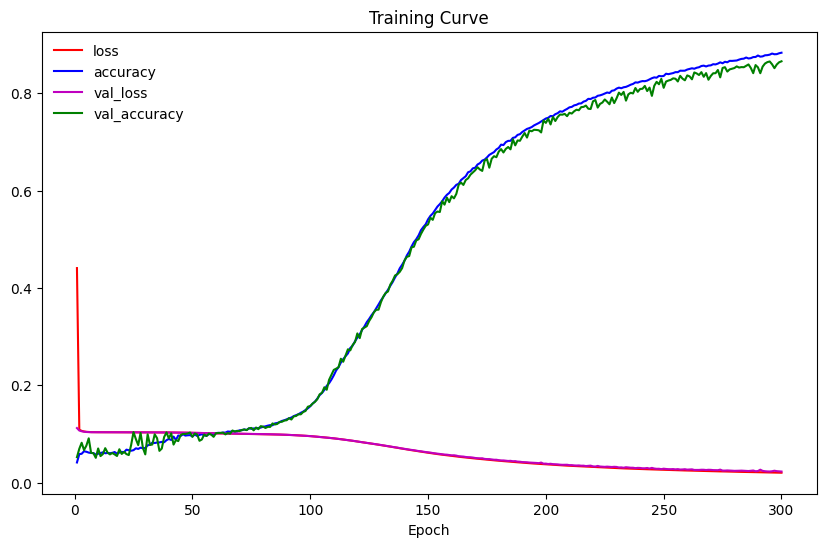

In [21]:
from helper_scripts.deep_learning import plot_loss_and_acc

plot_loss_and_acc(history.history, epochs)
model.save(os.path.join(log_dir, 'Model.h5'))

### Fitting with Data Augmentation:

We can use Keras' `ImageDataGenerator`:

In [22]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
np.random.seed(0)

In [23]:
loss = 'binary_crossentropy' 
optimizer = 'sgd' 

model = LeNetModel(num_classes)
model.compile(loss=loss , optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_3 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 576)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [25]:
log_dir = os.path.join(root_log_dir, 'with_augmentation')

checkpoint_path = os.path.join(log_dir, 'best_val_acc_weights.h5')
checkpoint_cb = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

In [26]:
time_cb = TimeHistory()

In [27]:
tensorboard_cb = TensorBoard(os.path.join(log_dir, 'tensorboard'))

In [29]:
history = model.fit(datagen.flow(
                        X_train.reshape(*X_train.shape, 1),# need to add fourth dimension of 1 apparently
                        y_train, batch_size=batch_size),
                    validation_data=datagen.flow(X_val.reshape(*X_val.shape, 1), y_val, batch_size=batch_size),
                    workers=4,
                    epochs=epochs, callbacks=[checkpoint_cb, time_cb, tensorboard_cb])

Epoch 1/300
853/858 [============================>.] - ETA: 0s - loss: 0.3651 - accuracy: 0.0360
Epoch 1: val_accuracy improved from -inf to 0.06342, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/with_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 12s 14ms/step - loss: 0.3637 - accuracy: 0.0361 - val_loss: 0.1199 - val_accuracy: 0.0634
Epoch 2/300
852/858 [============================>.] - ETA: 0s - loss: 0.1157 - accuracy: 0.0597
Epoch 2: val_accuracy did not improve from 0.06342
858/858 [==============================] - 12s 14ms/step - loss: 0.1157 - accuracy: 0.0598 - val_loss: 0.1129 - val_accuracy: 0.0539
Epoch 3/300
853/858 [============================>.] - ETA: 0s - loss: 0.1116 - accuracy: 0.0557
Epoch 3: val_accuracy did not improve from 0.06342
858/858 [==============================] - 13s 16ms/step - loss: 0.1115 - accuracy: 0.0556 - val_loss: 0.1101 - val_accuracy: 0.0630
Epoch 4/300
854/858 [========================

858/858 [==============================] - 11s 13ms/step - loss: 0.1038 - accuracy: 0.0659 - val_loss: 0.1037 - val_accuracy: 0.0708
Epoch 29/300
857/858 [============================>.] - ETA: 0s - loss: 0.1038 - accuracy: 0.0660
Epoch 29: val_accuracy did not improve from 0.08170
858/858 [==============================] - 13s 15ms/step - loss: 0.1038 - accuracy: 0.0659 - val_loss: 0.1037 - val_accuracy: 0.0639
Epoch 30/300
851/858 [============================>.] - ETA: 0s - loss: 0.1038 - accuracy: 0.0667
Epoch 30: val_accuracy did not improve from 0.08170
858/858 [==============================] - 14s 16ms/step - loss: 0.1038 - accuracy: 0.0667 - val_loss: 0.1037 - val_accuracy: 0.0668
Epoch 31/300
858/858 [==============================] - ETA: 0s - loss: 0.1038 - accuracy: 0.0676
Epoch 31: val_accuracy did not improve from 0.08170
858/858 [==============================] - 12s 14ms/step - loss: 0.1038 - accuracy: 0.0676 - val_loss: 0.1037 - val_accuracy: 0.0636
Epoch 32/300
853/8

Epoch 56/300
854/858 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.0862
Epoch 56: val_accuracy did not improve from 0.08467
858/858 [==============================] - 13s 15ms/step - loss: 0.1028 - accuracy: 0.0864 - val_loss: 0.1028 - val_accuracy: 0.0824
Epoch 57/300
855/858 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.0853
Epoch 57: val_accuracy did not improve from 0.08467
858/858 [==============================] - 12s 14ms/step - loss: 0.1027 - accuracy: 0.0854 - val_loss: 0.1027 - val_accuracy: 0.0798
Epoch 58/300
852/858 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.0859
Epoch 58: val_accuracy did not improve from 0.08467
858/858 [==============================] - 13s 15ms/step - loss: 0.1027 - accuracy: 0.0858 - val_loss: 0.1026 - val_accuracy: 0.0813
Epoch 59/300
853/858 [============================>.] - ETA: 0s - loss: 0.1026 - accuracy: 0.0855
Epoch 59: val_accuracy did not improve from 0.08467
8

Epoch 84/300
853/858 [============================>.] - ETA: 0s - loss: 0.1014 - accuracy: 0.0892
Epoch 84: val_accuracy improved from 0.08714 to 0.08816, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/with_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 11s 13ms/step - loss: 0.1014 - accuracy: 0.0890 - val_loss: 0.1015 - val_accuracy: 0.0882
Epoch 85/300
854/858 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.0886
Epoch 85: val_accuracy did not improve from 0.08816
858/858 [==============================] - 12s 13ms/step - loss: 0.1013 - accuracy: 0.0889 - val_loss: 0.1014 - val_accuracy: 0.0857
Epoch 86/300
856/858 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.0919
Epoch 86: val_accuracy did not improve from 0.08816
858/858 [==============================] - 11s 13ms/step - loss: 0.1013 - accuracy: 0.0917 - val_loss: 0.1014 - val_accuracy: 0.0847
Epoch 87/300
853/858 [==============

858/858 [==============================] - 12s 14ms/step - loss: 0.1007 - accuracy: 0.0970 - val_loss: 0.1009 - val_accuracy: 0.0966
Epoch 111/300
853/858 [============================>.] - ETA: 0s - loss: 0.1007 - accuracy: 0.0964
Epoch 111: val_accuracy improved from 0.09657 to 0.09980, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/with_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 12s 13ms/step - loss: 0.1007 - accuracy: 0.0964 - val_loss: 0.1008 - val_accuracy: 0.0998
Epoch 112/300
851/858 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.0983
Epoch 112: val_accuracy did not improve from 0.09980
858/858 [==============================] - 11s 13ms/step - loss: 0.1006 - accuracy: 0.0980 - val_loss: 0.1008 - val_accuracy: 0.0965
Epoch 113/300
852/858 [============================>.] - ETA: 0s - loss: 0.1006 - accuracy: 0.0990
Epoch 113: val_accuracy did not improve from 0.09980
858/858 [=====================

858/858 [==============================] - 12s 14ms/step - loss: 0.1001 - accuracy: 0.1039 - val_loss: 0.1002 - val_accuracy: 0.1012
Epoch 137/300
854/858 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.1043
Epoch 137: val_accuracy did not improve from 0.10125
858/858 [==============================] - 11s 13ms/step - loss: 0.1001 - accuracy: 0.1044 - val_loss: 0.1003 - val_accuracy: 0.0989
Epoch 138/300
852/858 [============================>.] - ETA: 0s - loss: 0.1001 - accuracy: 0.1044
Epoch 138: val_accuracy did not improve from 0.10125
858/858 [==============================] - 12s 13ms/step - loss: 0.1001 - accuracy: 0.1045 - val_loss: 0.1002 - val_accuracy: 0.1012
Epoch 139/300
854/858 [============================>.] - ETA: 0s - loss: 0.1000 - accuracy: 0.1047
Epoch 139: val_accuracy improved from 0.10125 to 0.10150, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/with_augmentation/best_val_acc_weights.h5
858/858 [=====================

858/858 [==============================] - 12s 14ms/step - loss: 0.0996 - accuracy: 0.1073 - val_loss: 0.0997 - val_accuracy: 0.1066
Epoch 164/300
851/858 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.1063
Epoch 164: val_accuracy did not improve from 0.10661
858/858 [==============================] - 11s 13ms/step - loss: 0.0996 - accuracy: 0.1066 - val_loss: 0.0997 - val_accuracy: 0.1012
Epoch 165/300
857/858 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.1047
Epoch 165: val_accuracy did not improve from 0.10661
858/858 [==============================] - 12s 14ms/step - loss: 0.0996 - accuracy: 0.1048 - val_loss: 0.0997 - val_accuracy: 0.1023
Epoch 166/300
856/858 [============================>.] - ETA: 0s - loss: 0.0995 - accuracy: 0.1093
Epoch 166: val_accuracy did not improve from 0.10661
858/858 [==============================] - 11s 13ms/step - loss: 0.0995 - accuracy: 0.1094 - val_loss: 0.0998 - val_accuracy: 0.1015
Epoch 167/30

858/858 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.1102
Epoch 191: val_accuracy did not improve from 0.10856
858/858 [==============================] - 12s 14ms/step - loss: 0.0991 - accuracy: 0.1102 - val_loss: 0.0993 - val_accuracy: 0.1076
Epoch 192/300
858/858 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.1103
Epoch 192: val_accuracy did not improve from 0.10856
858/858 [==============================] - 12s 14ms/step - loss: 0.0991 - accuracy: 0.1103 - val_loss: 0.0992 - val_accuracy: 0.1076
Epoch 193/300
856/858 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.1127
Epoch 193: val_accuracy did not improve from 0.10856
858/858 [==============================] - 12s 13ms/step - loss: 0.0990 - accuracy: 0.1128 - val_loss: 0.0993 - val_accuracy: 0.1075
Epoch 194/300
854/858 [============================>.] - ETA: 0s - loss: 0.0990 - accuracy: 0.1120
Epoch 194: val_accuracy improved from 0.10856 to 0.10958, sa

855/858 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.1154
Epoch 218: val_accuracy did not improve from 0.11324
858/858 [==============================] - 11s 13ms/step - loss: 0.0987 - accuracy: 0.1154 - val_loss: 0.0989 - val_accuracy: 0.1124
Epoch 219/300
852/858 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.1157
Epoch 219: val_accuracy improved from 0.11324 to 0.11341, saving model to ../model_fit_results/GTSRB/LeNet/2022-02-21_00_01_S/with_augmentation/best_val_acc_weights.h5
858/858 [==============================] - 12s 14ms/step - loss: 0.0986 - accuracy: 0.1154 - val_loss: 0.0989 - val_accuracy: 0.1134
Epoch 220/300
852/858 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.1138
Epoch 220: val_accuracy did not improve from 0.11341
858/858 [==============================] - 11s 13ms/step - loss: 0.0986 - accuracy: 0.1139 - val_loss: 0.0989 - val_accuracy: 0.1108
Epoch 221/300
853/858 [=====================

856/858 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.1170
Epoch 245: val_accuracy did not improve from 0.11885
858/858 [==============================] - 11s 13ms/step - loss: 0.0982 - accuracy: 0.1170 - val_loss: 0.0984 - val_accuracy: 0.1140
Epoch 246/300
857/858 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.1178
Epoch 246: val_accuracy did not improve from 0.11885
858/858 [==============================] - 12s 14ms/step - loss: 0.0982 - accuracy: 0.1178 - val_loss: 0.0984 - val_accuracy: 0.1147
Epoch 247/300
855/858 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.1159
Epoch 247: val_accuracy did not improve from 0.11885
858/858 [==============================] - 12s 14ms/step - loss: 0.0982 - accuracy: 0.1159 - val_loss: 0.0985 - val_accuracy: 0.1127
Epoch 248/300
852/858 [============================>.] - ETA: 0s - loss: 0.0982 - accuracy: 0.1180
Epoch 248: val_accuracy did not improve from 0.11885
858/858

Epoch 273/300
850/858 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.1199
Epoch 273: val_accuracy did not improve from 0.12080
858/858 [==============================] - 12s 14ms/step - loss: 0.0978 - accuracy: 0.1198 - val_loss: 0.0980 - val_accuracy: 0.1173
Epoch 274/300
852/858 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.1217
Epoch 274: val_accuracy did not improve from 0.12080
858/858 [==============================] - 12s 13ms/step - loss: 0.0977 - accuracy: 0.1216 - val_loss: 0.0980 - val_accuracy: 0.1178
Epoch 275/300
853/858 [============================>.] - ETA: 0s - loss: 0.0977 - accuracy: 0.1209
Epoch 275: val_accuracy did not improve from 0.12080
858/858 [==============================] - 12s 13ms/step - loss: 0.0977 - accuracy: 0.1208 - val_loss: 0.0980 - val_accuracy: 0.1126
Epoch 276/300
855/858 [============================>.] - ETA: 0s - loss: 0.0978 - accuracy: 0.1191
Epoch 276: val_accuracy did not improve from 0

In [30]:
time_cb.save_fit_times_csv(os.path.join(log_dir, 'fit_times.csv'))
print(f'Total fit time was {time.strftime("%H:%M:%S", time.gmtime(time_cb.total_fit_time))} seconds')

Total fit time was 00:58:43 seconds


In [31]:
# load optimal model
model.load_weights(checkpoint_path)

scores = model.evaluate(X_test, y_test, verbose=1)

395/395 [==============================] - 1s 2ms/step - loss: 0.0981 - accuracy: 0.1181


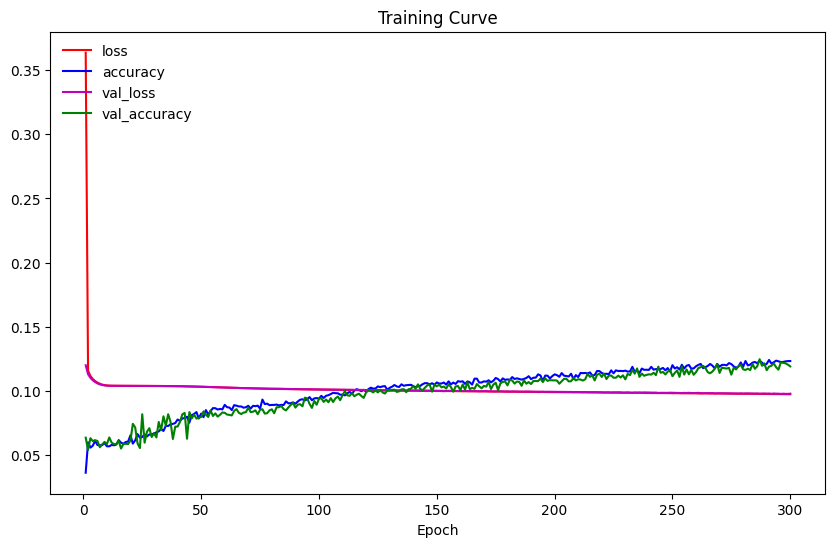

In [34]:
plot_loss_and_acc(history.history, epochs)
model.save(os.path.join(log_dir, 'Model.h5'))